In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
BSIZE_SP = 512
MDATA_LIST = [b'title', b'date', b'plotname', b'flags',
              b'no. variables', b'no. points', b'dimensions',
              b'command', b'option']

class NGSpiceRaw:
    def __init__(self, fname: str, live: bool = True):
        self.fname = fname
        self.live = live

        self._reload()

    def _reload(self):
        self.arrs, self.plots = self._read_raw(self.fname)
        self.plot, self.arr = self.plots[-1], self.arrs[-1]
        print(f"Loaded {len(self.plots)} plots from {self.fname}")

    def _read_raw(self, fname: str):
        """
        Read a binary ngspice .raw file.

        Returns:
          arrs  : list of numpy structured arrays, one per plot
          plots : list of metadata dicts, parallel to arrs
        """
        with open(fname, 'rb') as fp:
            arrs = []
            plots = []
            plot = {}
            while True:
                line = fp.readline(BSIZE_SP)
                if not line:
                    break
                parts = line.split(b':', 1)
                if len(parts) != 2:
                    continue
                key, val = parts[0].lower(), parts[1].strip()
                if key in MDATA_LIST:
                    plot[key] = val
                if key == b'variables':
                    nvars   = int(plot[b'no. variables'])
                    npoints = int(plot[b'no. points'])
                    plot['varnames'] = []
                    plot['varunits'] = []
                    for _ in range(nvars):
                        ascii_line = fp.readline(BSIZE_SP).decode('ascii')
                        idx, name, *unit = ascii_line.split()
                        plot['varnames'].append(name)
                        plot['varunits'].append(unit[0])
                if key == b'binary':
                    # build dtype (complex if flagged, else float)
                    fmt = np.complex_ if b'complex' in plot[b'flags'] else float
                    row_dtype = np.dtype({
                        'names':   plot['varnames'],
                        'formats': [fmt]*len(plot['varnames'])
                    })
                    # read data block
                    data = np.fromfile(fp, dtype=row_dtype, count=npoints)
                    arrs.append(data)
                    plots.append(plot.copy())
                    plot.clear()
                    fp.readline()

        return arrs, plots
    
    def select(self, idx: int):
        """
        Select a plot by index.
        """
        if idx < -len(self.plots) or idx >= len(self.plots):
            raise IndexError("Index out of range")
        
        self.plot = self.plots[idx]
        self.arr = self.arrs[idx]

        return self.plot, self.arr
    
    @property
    def names(self):
        return self.arr.dtype.names
    
    def __getitem__(self, key):
        """
        Get a variable by name or index.
        """
        if self.live:
            self._reload()

        if key in self.names:
            return self.arr[key]
        else:
            raise KeyError(f"Variable '{key}' not found")
        
    def __setitem__(self, key, value):
        """
        Set a variable by name or index.
        """
        if self.live:
            self._reload()

        if key in self.names:
            raise KeyError(f"Variable '{key}' already exists")
        else:
            # Add new variable to the array
            new_dtype = np.dtype(self.arr.dtype.descr + [(key, value.dtype)])
            new_arr = np.zeros(self.arr.shape, dtype=new_dtype)
            for name in self.names:
                new_arr[name] = self.arr[name]
            new_arr[key] = value
            self.arr = new_arr
            self.arrs[-1] = new_arr
            self.plot['varnames'].append(key)
            self.plot['varunits'].append('')
            self.plot[b'no. variables'] = str(len(self.plot['varnames']))
            self.plot[b'no. points'] = str(len(self.arr))
            

In [56]:
from typing import Optional

def plot_digital_signals(raw: NGSpiceRaw, signals: list[str], time_range: Optional[tuple[float, float]] = None, spacing: float = 1.25):

    time = raw['time']

    plt.figure(figsize=(16, 2 + len(signals)))
    plt.title(raw.plot[b'title'].decode('ascii'))

    added_signals = []
    for i, signal in enumerate(signals):
        if isinstance(signal, str):
            signal_name = f"v({signal.lower()})" if '(' not in signal else signal.lower()
            if signal_name not in raw.names:
                print(f"Signal '{signal_name}' not found in raw data")
                continue

            signal = raw[signal_name]
            
        elif isinstance(signal, tuple):
            signal_name = signal[0]
            signal = signal[1]

            if signal.ndim != 1:
                print(f"Signal '{signal[1]}' is not a 1D array")
                continue

        else:
            print(f"Unsupported signal type: {type(signal)}")
            continue

        plt.axhline(-i * spacing, color='black', lw=1.0, ls='--')
        plt.axhline(-i * spacing + 0.5, color='black', lw=0.75, ls='--')
        plt.axhline(-i * spacing + 1.0, color='black', lw=1.0, ls='--')
        # Gray background for each signal
        plt.fill_between(time, -i * spacing, -i * spacing + 1.0, color='lightgray', alpha=0.5)

        if signal.max() != signal.min():
            signal = (signal - signal.min()) / (signal.max() - signal.min())
        elif signal.max() == 0:
            signal = np.zeros_like(signal)
        else:
            signal = np.ones_like(signal)

        plt.plot(time, signal - i * spacing)
        added_signals.append(signal_name)

    # Replace y label ticks with signal names
    plt.xlabel('Time [s]')
    labels = plt.yticks([-i * spacing for i in range(len(added_signals))], added_signals)
    for i, label in enumerate(labels[1]):
        label.set_horizontalalignment('right')
        label.set_verticalalignment('bottom')
        label.set_color(f"C{i}")

    if time_range is not None:
        plt.xlim(time_range)
    else:
        plt.xlim(time[0], time[-1])

    plt.grid(axis='x', which='both', lw=0.75, ls='--', color='black')
    plt.show()

In [84]:
raw = NGSpiceRaw('../designs/basic1/simulation/adc_tb.raw', live=False)

Loaded 1 plots from ../designs/basic1/simulation/adc_tb.raw


In [85]:
print("Fields:", raw.names)

Fields: ('time', 'v(x1.x1.nctrl)', 'v(x1.sample_o)', 'v(vss)', 'v(vdd)', 'v(x1.sample)', 'v(in_ai)', 'v(x1.x3.xc2.1)', 'v(x1.x3.l1)', 'v(x1.x3.xc3.1)', 'v(x1.x3.l2)', 'v(x1.x3.xc4.1)', 'v(x1.x3.l3)', 'v(x1.x3.xc5.1)', 'v(x1.dac_o0)', 'v(x1.dac_o1)', 'v(x1.dac_o2)', 'v(x1.x3.l4)', 'v(x1.dac_o3)', 'v(x1.x3.xc6.1)', 'v(x1.x3.xc7.1)', 'v(x1.x3.l5)', 'v(x1.x3.xc8.1)', 'v(x1.x3.l6)', 'v(x1.x3.xc9.1)', 'v(x1.x3.l7)', 'v(x1.dac_o4)', 'v(x1.dac_o5)', 'v(x1.dac_o6)', 'v(x1.x3.l8)', 'v(x1.dac_o7)', 'v(x1.x3.xc1.1)', 'v(clk_digital_i)', 'v(x1.comp_a)', 'v(x1.x2.neg_buf)', 'v(clk_comp_i)', 'v(x1.x2.pos_buf)', 'v(x1.x2.net1)', 'v(x1.x2.net2)', 'v(x1.clk_comp_ni)', 'v(x1.comp_real_pos)', 'v(x1.comp_real_neg)', 'v(x1.x2.xc1.1)', 'v(x1.x2.xc2.1)', 'v(x1.comp_real)', 'v(x1.x5.a_27_112_)', 'v(x1.x5.net1)', 'v(rst_ni)', 'v(start_i)', 'v(result_o0)', 'v(ready_o)', 'v(result_o1)', 'v(result_o2)', 'v(result_o3)', 'v(result_o4)', 'v(result_o5)', 'v(result_o6)', 'v(result_o7)', 'i(v5)', 'i(vss)', 'i(vdd)', 'i(

In [99]:
test_voltages = np.arange(0, 1.5, 0.1)
test_initial_time = 9
test_interval_time = 12


test_times = np.arange(test_initial_time, test_initial_time + len(test_voltages) * test_interval_time, test_interval_time)
test_times_dup = np.repeat(test_times, 2)
# Insert 0 at the beginning
test_times_dup = np.insert(test_times_dup, 0, 0)
# Remove the last time point, as it is not needed
test_times_dup = test_times_dup[:-1]
print("Test times:", test_times)

test_voltages_dup = np.repeat(test_voltages, 2)
print("Test voltages:", test_voltages)

result = "pwl("
for t, v in zip(test_times_dup, test_voltages_dup):
    if t != 0:
        result += f"{{{t:d}/f}} {v:.2f} "
    else:
        result += f"0 {v:.2f} "

result = result.strip() + ")"
print("Result:", result)

Test times: [  9  21  33  45  57  69  81  93 105 117 129 141 153 165 177]
Test voltages: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]
Result: pwl(0 0.00 {9/f} 0.00 {9/f} 0.10 {21/f} 0.10 {21/f} 0.20 {33/f} 0.20 {33/f} 0.30 {45/f} 0.30 {45/f} 0.40 {57/f} 0.40 {57/f} 0.50 {69/f} 0.50 {69/f} 0.60 {81/f} 0.60 {81/f} 0.70 {93/f} 0.70 {93/f} 0.80 {105/f} 0.80 {105/f} 0.90 {117/f} 0.90 {117/f} 1.00 {129/f} 1.00 {129/f} 1.10 {141/f} 1.10 {141/f} 1.20 {153/f} 1.20 {153/f} 1.30 {165/f} 1.30 {165/f} 1.40 {177/f} 1.40)


In [100]:
# out_diff = raw['v(out2)'] - raw['v(out1)']

# out_cleaned = np.where(raw['v(out2)'] > 0.9, np.where(raw['v(out1)'] < 0.9, 1.0, 0.0), 0.0)

result = np.zeros_like(raw['v(result_o0)'])
for i in range(8):
    result += np.where(raw[f'v(result_o{i})'] > 0.75, 1, 0) * (2 ** (7 - i))

# No negative values in result, as well as no values above 255
result = np.clip(result, 0, 255)

# Round up/down to nearest integer
result = np.round(result).astype(int)

In [101]:
sampling_freq = 10e6
initial_sampling_time = 14

average_timestep = np.diff(raw['time']).mean()
print(f"Average timestep: {average_timestep * 1e9:.2f} ns")

initial_time = initial_sampling_time / sampling_freq
timestep = test_interval_time / sampling_freq

result_times = [initial_time]
while result_times[-1] + timestep < raw['time'][-1]:
    result_times.append(result_times[-1] + timestep)

result_times = np.array(result_times)
print(f"Sampling at times: {result_times}")

result_values = []
for t in result_times:
    idx = np.argmin(np.abs(raw['time'] - t))
    result_values.append(result[idx])
result_values = np.array(result_values)
print(f"Result values:    {result_values}")

results_expected = (test_voltages * 0xFF / 1.5).astype(int)[:len(result_values)]
print(f"Expected results: {results_expected}")

results_error = result_values - results_expected
print(f"Error:            {results_error}")

Average timestep: 0.69 ns
Sampling at times: [1.40e-06 2.60e-06 3.80e-06 5.00e-06 6.20e-06 7.40e-06 8.60e-06 9.80e-06
 1.10e-05 1.22e-05 1.34e-05]
Result values:    [  0  16  33  50  67  85 103 117 135 154 171]
Expected results: [  0  17  34  51  68  85 102 119 136 153 170]
Error:            [ 0 -1 -1 -1 -1  0  1 -2 -1  1  1]


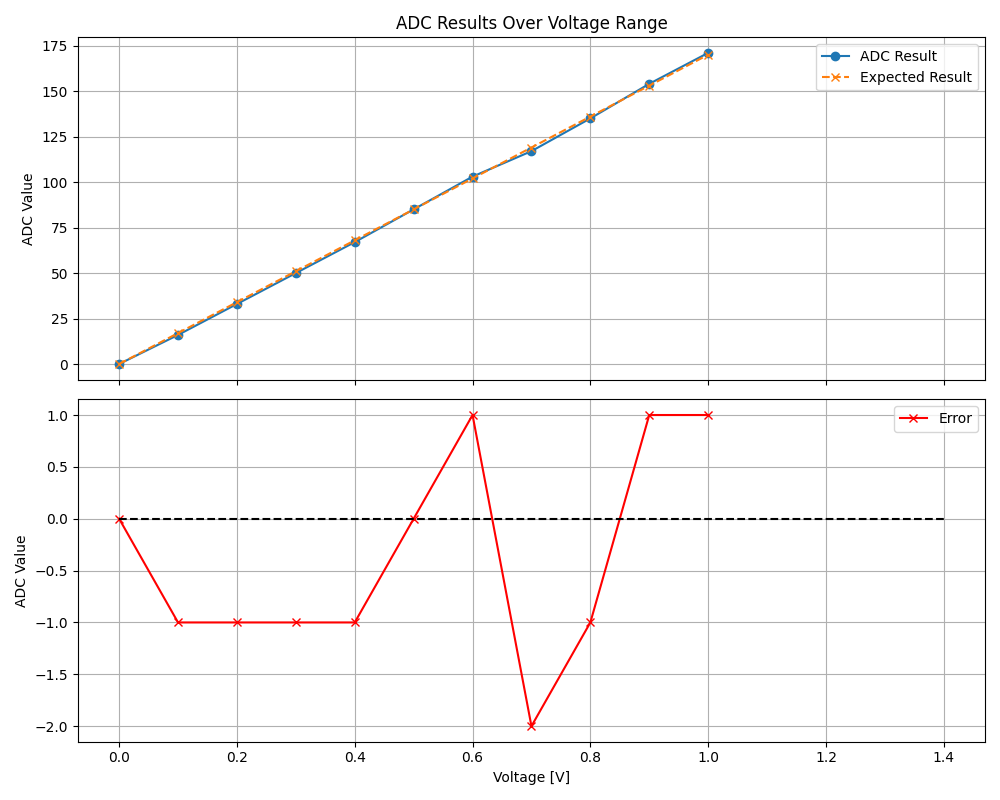

In [108]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].plot(test_voltages[:len(result_values)], result_values, marker='o', label='ADC Result')
ax[0].plot(test_voltages[:len(results_expected)], results_expected, marker='x', label='Expected Result', linestyle='--')
ax[0].set_title('ADC Results Over Voltage Range')
ax[0].set_ylabel('ADC Value')
ax[0].legend()
ax[0].grid()
ax[1].plot(test_voltages[:len(result_values)], results_error, marker='x', color='red', label='Error')
ax[1].hlines(0, test_voltages[0], test_voltages[-1], colors='black', linestyles='--')
ax[1].set_xlabel('Voltage [V]')
ax[1].set_ylabel('ADC Value')
ax[1].legend()
ax[1].grid()
plt.tight_layout()
plt.show()

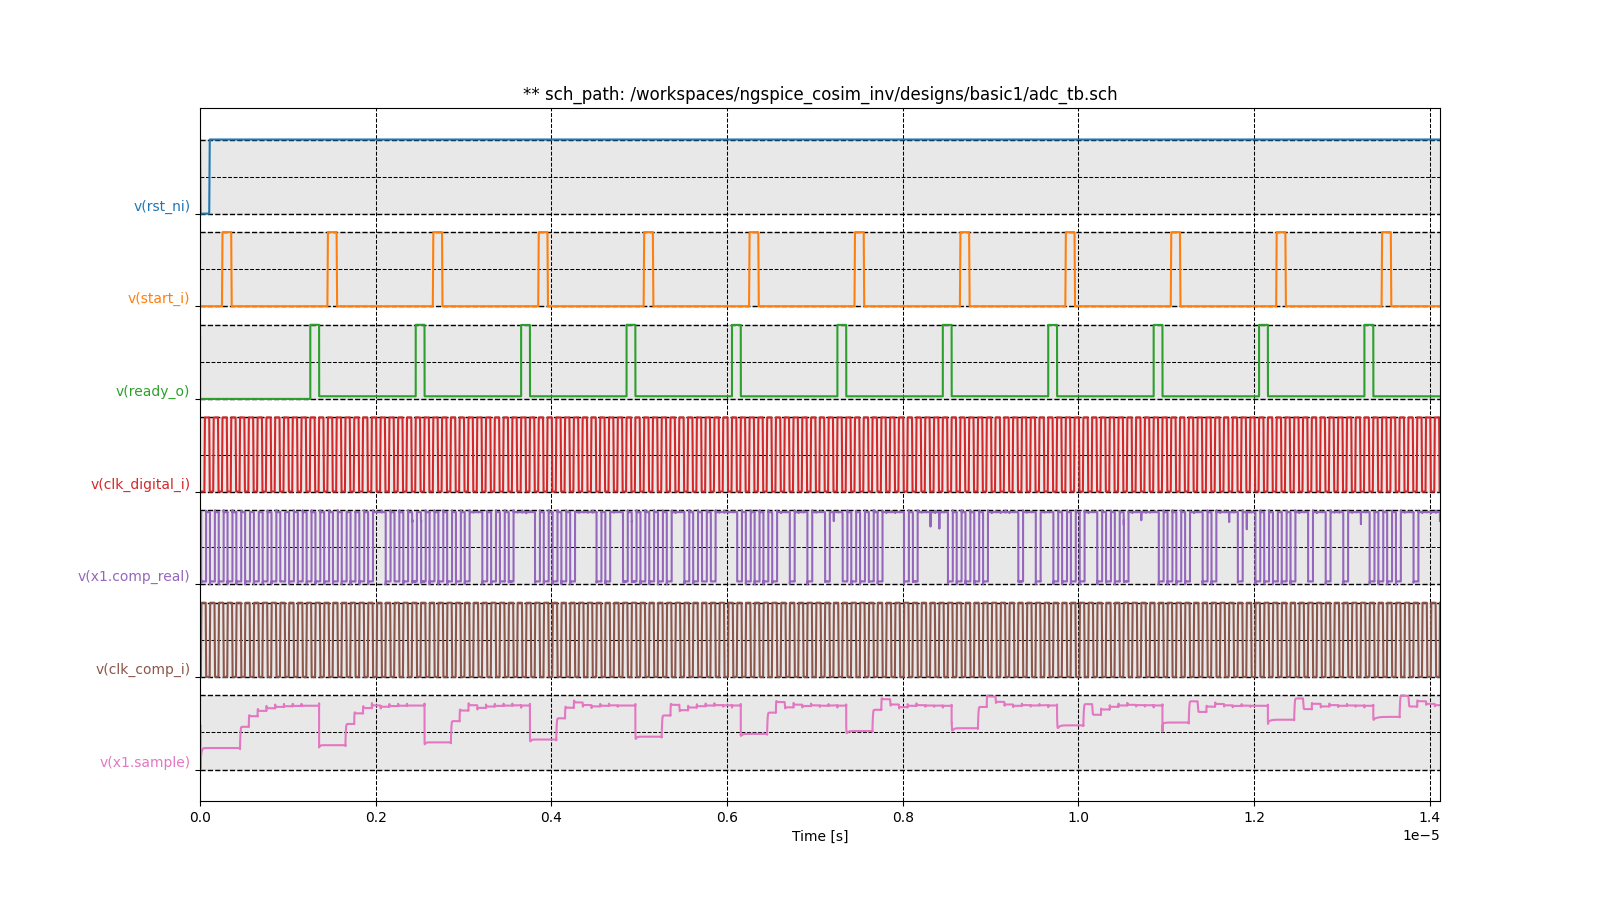

In [103]:
%matplotlib widget

plot_digital_signals(
    raw,
    ['rst_ni', 'start_i', 'ready_o', 'clk_digital_i', 'x1.comp_real', 'clk_comp_i', 'x1.sample'],
    # time_range=(2.45e-5, 2.65e-5)
)